In [84]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, dayofweek, hour, lag, mean, lit, when,avg
from pyspark.sql.window import Window
import json
from pyspark.sql.functions import rand, isnan, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import rand, round
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
from tensorflow.keras.utils import to_categorical

# Initialize a SparkSession
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Load your dataset into a PySpark DataFrame
df = spark.read.csv('/Users/mac/Downloads/predictive2.csv', header=True, inferSchema=True)
df.count()
df = df.limit(100000)
df.count()
# Assuming 'date_insertion' is the correct timestamp column based on your dataset schema
# Adjust the following transformations accordingly:

# Extract JSON fields function
def extract_from_json(column, key):
    try:
        json_data = json.loads(column.replace("'", "\""))
        return json_data.get(key, None)
    except:
        return None

# Registering the UDF
extract_from_json_udf = udf(extract_from_json)

# Step 1: Extracting 'oil_value' and 'fuel_liters'
df = df.withColumn("oil_value", extract_from_json_udf(col("details"), lit("oil_value")))
df = df.withColumn("fuel_liters", extract_from_json_udf(col("details"), lit("fuel_liters")))

# Step 2: Creating time-based features
df = df.withColumn("date_insertion", to_date(col("date_insertion")))
df = df.withColumn("day_of_week", dayofweek(col("date_insertion")))
df = df.withColumn("hour_of_day", hour(col("date_insertion")))



# Step 4: Aggregate readings on a daily basis
daily_avg_df = df.groupBy("thing_id", "date_insertion").agg(mean("power_supply_voltage").alias("daily_avg_voltage"))
df = df.join(daily_avg_df, ["thing_id", "date_insertion"], "left")

# Step 5: Create binary indicator for 'engine_status'
df = df.withColumn("engine_alert", when(col("engine_status") == "Abnormal", 1).otherwise(0))

# Define a UDF to generate random values within a range
def random_value(min_value, max_value):
    return (rand() * (max_value - min_value) + min_value).cast(FloatType())

# random_value_udf = udf(random_value, FloatType())

# Set min and max values for 'oil_value' and 'fuel_liters'
oil_value_min, oil_value_max = 0, 4
fuel_liters_min, fuel_liters_max = 0, 60

fuel_liters_mi, fuel_liters_ma = 2, 6


# Replace null values with random numbers
# Replace null values with random numbers and round to 1 decimal place
df = df.withColumn("oil_value", when(df['oil_value'].isNull(), round((rand() * (oil_value_max - oil_value_min) + oil_value_min), 1)).otherwise(df['oil_value']))
df = df.withColumn("fuel_liters", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_max - fuel_liters_min) + fuel_liters_min), 1)).otherwise(df['fuel_liters']))
# df = df.withColumn("fuel_change", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_ma - fuel_liters_mi) + fuel_liters_mi), 1)).otherwise(df['fuel_liters']))








# Step 6: Generate interaction features
# df = df.withColumn("voltage_current_interaction", col("power_supply_voltage") * col("battery_current"))

# Step 3: Calculating rate of change for 'battery_current'
windowSpec = Window.partitionBy("thing_id").orderBy("date_insertion")
df = df.withColumn("battery_current_change", col("power_supply_voltage") - lag("power_supply_voltage", 1).over(windowSpec))


In [85]:
df.count()


100000

In [86]:
df = df.select("thing_id", "date_insertion", "speed", "total_km", "engine_status", "power_supply_voltage" ,"oil_value", "fuel_liters",  "battery_current_change", "daily_avg_voltage")


from pyspark.sql import Window
from pyspark.sql.functions import lag, avg, stddev

# Define a window
window = Window.orderBy('date_insertion').rowsBetween(-9, 0)  # assuming 'date_insertion' is your time column

# Calculate rolling averages and standard deviations
# df = df.withColumn('speed_avg', avg(df['speed']).over(window))
# df = df.withColumn('oil_value_std', stddev(df['oil_value']).over(window))

# Calculate changes between consecutive readings
# df = df.withColumn('speed_change', df['speed'] - lag(df['speed']).over(Window.orderBy('date_insertion')))
# df = df.withColumn('fuel_change', df['fuel_liters'] - lag(df['fuel_liters']).over(Window.orderBy('date_insertion')))
df = df.withColumn('fuel_change', (rand() * 4 + 2).cast("int"))#replace all fuel_chnages values with random values between 2 and 6



# Step 7: Calculate rolling average


# Define a Window specification 
# windowSpec = Window.orderBy('date_insertion').rowsBetween(-4, 0)  # 5 rows including current row

# Calculate rolling average
# df = df.withColumn('oil_quality_rolling_avg', avg(df['oil_value']).over(windowSpec))

# Show the first 5 rows of the DataFrame
df.show()


+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      3.5|       20.5|                  NULL|22.23008032128516|          4|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.4|       47.1|  -0.01000000000000...|22.23008032128516|          5|
|     802|    2024-02-28|    0|275680962|            0|               19.88|      2.8|       31.7|  -0.01999999999999...|22.23008032128516|          2|
|     802|    2024-02-28|    0|275680962|            0|               19.87|      0.7|  

In [87]:
# Define thresholds
oil_value_fail_threshold = 1
oil_value_about_to_fail_threshold = 2

df = df.withColumn("car_age", when(rand() < 0.7, "old").otherwise("new"))

df = df.withColumn("last_oil_change", 
                   when(rand() < 0.25, "new")
                   .when((rand() >= 0.25) & (rand() < 0.5), "50km")
                   .when((rand() >= 0.5) & (rand() < 0.75), "80km")
                   .otherwise("old"))

                #    when((col("fuel_change") > 30) , "fail")


                #     when((col("fuel_change") > 5)  & (col("car_age") == "new"), "about fail")
                #    .when((col("fuel_change") > 4)& (col("car_age") == "old"), "about fail")
                #    .when((col("car_age") == "old") & (col("last_oil_change") == "80km"), "about to fail")
                #    .when((col("car_age") == "new") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km") | (col("last_oil_change") == "80km")), "normal")

df = df.withColumn("status", 
                    when((col("fuel_change") > 30) , "fail")
                    .when((col("fuel_change") > 5)  & (col("car_age") == "new"), "about fail")
                   .when((col("fuel_change") > 4)& (col("car_age") == "old"), "about fail")
                   .when((col("car_age") == "old") & (col("last_oil_change") == "80km"), "about to fail")
                   .when((col("car_age") == "new") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km") | (col("last_oil_change") == "80km")), "normal")
                   .when((col("car_age") == "old") & (col("last_oil_change") == "old"), "fail")
                   .when((col("car_age") == "old") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km")), "normal")
                   .otherwise("about to fail"))

# df = df.drop("date_insertion", "speed",)



from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

# Define a UDF that changes "about to fail" to "fail" with a 5% probability
def change_status(status):
    if status == "fail" and random.random() < 0.2:
        return "Noraml"
    
    # if status == "normal" and random.random() < 0.06:
    #     return "fail"
    else:
        return status

change_status_udf = udf(change_status, StringType())

# Apply the UDF to the "status" column
df = df.withColumn("status", change_status_udf(df["status"]))


df.show()


+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+-------------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|car_age|last_oil_change|       status|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+-------------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      3.5|       20.5|                  NULL|22.23008032128516|          4|    new|            new|       normal|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.4|       47.1|  -0.01000000000000...|22.23008032128516|          5|    old|           80km|   about fail|
|     802|    2024-02-28|    0|275680962|         

In [88]:
from pyspark.ml.feature import StringIndexer
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pyspark.ml.feature import OneHotEncoder



df = df.withColumn("status", 
                   when(col("status") == "normal", 0)
                   .when(col("status") == "about to fail", 1)
                   .otherwise(2))

df = df.withColumn("car_age", 
                   when(col("car_age") == "old", 0)
                   .when(col("car_age") == "new", 1)



)


df = df.withColumn("last_oil_change", 
                   when(col("last_oil_change") == "new", 0)
                   .when(col("last_oil_change") == "50km", 1)
                   .when(col("last_oil_change") == "80km", 2)
                   .otherwise(3))

df.show(3)

# Cast 'statusIndex' to integer

# Select features and label
features = df.drop('status')
label = df.select('status')

# Convert Spark DataFrame to pandas DataFrame
features_pd = features.toPandas()
label_pd = label.toPandas()


# Remove rows with any null value
features_pd = features_pd.dropna()
label_pd = label_pd.loc[features_pd.index] 

# Remove 'thing_id' and 'date' from features
features_pd = features_pd.drop(['thing_id', 'date_insertion','speed','total_km','battery_current_change','daily_avg_voltage'], axis=1)

features_pd.head()


# Convert pandas DataFrame to NumPy array
features_array = features_pd.values
label_array = label_pd.values

# Convert labels to one-hot encoded format
label_array = to_categorical(label_array, num_classes=3)

# Scale features to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features_array)



# Reshape to 3D array (batch_size, timesteps, input_dim)
scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|car_age|last_oil_change|status|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      3.5|       20.5|                  NULL|22.23008032128516|          4|      1|              0|     0|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.4|       47.1|  -0.01000000000000...|22.23008032128516|          5|      0|              2|     2|
|     802|    2024-02-28|    0|275680962|            0|               19.88|      2.8

In [89]:
features_pd.head(10)




,engine_status,power_supply_voltage,oil_value,fuel_liters,fuel_change,car_age,last_oil_change
1,0,19.90,2.4,47.1,5,0,2
2,0,19.88,2.8,31.7,2,0,2
3,0,19.87,0.7,1.3,3,0,1
4,0,19.87,3.4,48.7,2,1,3
5,0,19.86,2.1,51.9,5,0,1
6,1,22.10,0.5,9.4,4,0,1
7,1,22.22,0.2,59.9,4,0,1
8,1,22.22,1.8,6.3,4,0,0
9,1,22.11,2.2,12.5,5,0,2
10,1,22.25,3.5,24.1,4,1,0


In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(50, input_shape=(scaled_features.shape[1], scaled_features.shape[2])))
# model.add(Dense(3,activation='softmax'))

# model.add(LSTM(5,return_sequences=False))

# Define the LSTM model
# model.add(Dense(5, return_sequences=False, input_shape=(scaled_features.shape[1], scaled_features.shape[2])))
model = Sequential()
model.add(Dense(5, activation='relu', input_shape=(7,)))
model.add(Dense(3, activation='softmax'))


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])# Fit the model

from sklearn.model_selection import train_test_split
import pickle

# Split the data into a training set and a test set

# Split the data into a training set and a test set
features_train, features_test, label_train, label_test = train_test_split(scaled_features, label_array, test_size=0.2, random_state=42)


# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

import tensorflow as tf

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='/Users/mac/Desktop', histogram_freq=1, write_graph=True)

features_train_reshaped = features_train.reshape((features_train.shape[0], -1))
history = model.fit(features_train_reshaped, label_train, epochs=10, batch_size=72, validation_split=0.2, shuffle=False, callbacks=[tensorboard_callback])

# Train the model on the training set
# history = model.fit(features_train, label_train, epochs=10, batch_size=72, validation_split=0.2, shuffle=False,callbacks=[tensorboard_callback])



# Assuming 'model' is your trained Keras model
model.save('my_model.h5')
model.save('/Users/mac/Documents/pfe/backend/datahub/pm_model.h5')


import joblib

# Assuming 'scaler' is your fitted MinMaxScaler
joblib.dump(scaler, 'my_scaler.pkl')




Epoch 1/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.5505 - loss: 0.9682 - val_accuracy: 0.7942 - val_loss: 0.5712
Epoch 2/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8062 - loss: 0.5134 - val_accuracy: 0.8146 - val_loss: 0.4036
Epoch 3/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.8169 - loss: 0.3932 - val_accuracy: 0.8244 - val_loss: 0.3504
Epoch 4/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.8316 - loss: 0.3398 - val_accuracy: 0.8487 - val_loss: 0.2995
Epoch 5/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.8498 - loss: 0.2909 - val_accuracy: 0.8625 - val_loss: 0.2533
Epoch 6/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.8654 - loss: 0.2446 - val_accuracy: 0.8765 - val_loss: 0.2062
Epoch 7/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8948 - loss: 0.1968 - val_accuracy: 0.9430 - val_loss: 0.1597
Epoch 8/10
888/888 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.9637 - loss: 0.1510 - 

['my_scaler.pkl']

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


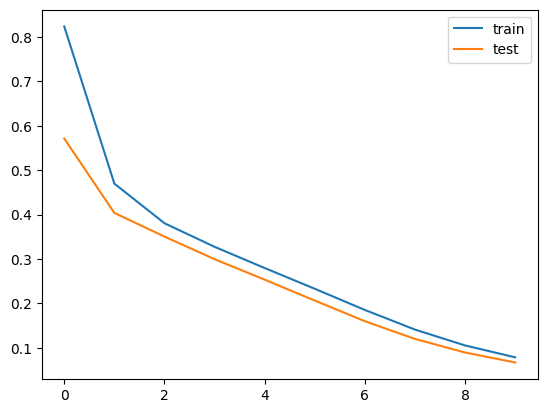

In [92]:
# Plot history
from matplotlib import pyplot
# Check the keys in the history object
print(history.history.keys())

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

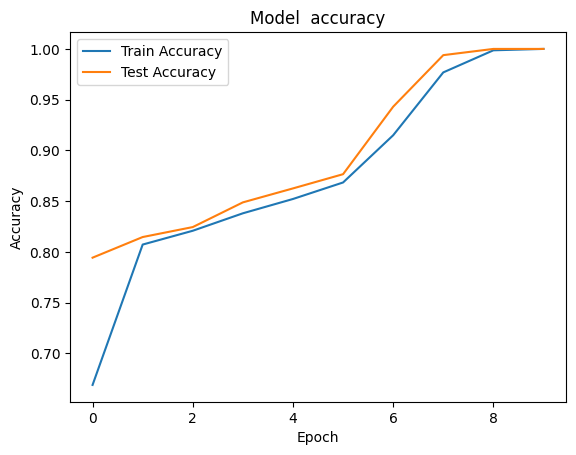

In [93]:


# Plot training & validation accuracy values
pyplot.plot(history.history['accuracy'], label='Train Accuracy')
pyplot.plot(history.history['val_accuracy'], label='Test Accuracy')

pyplot.title('Model  accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend()
pyplot.show()

In [94]:
features_test_reshaped = features_test.reshape((features_test.shape[0], -1))

predictions = model.predict(features_test_reshaped)
# Make predictions on the test set
# predictions = model.predict(features_test)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)



625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step


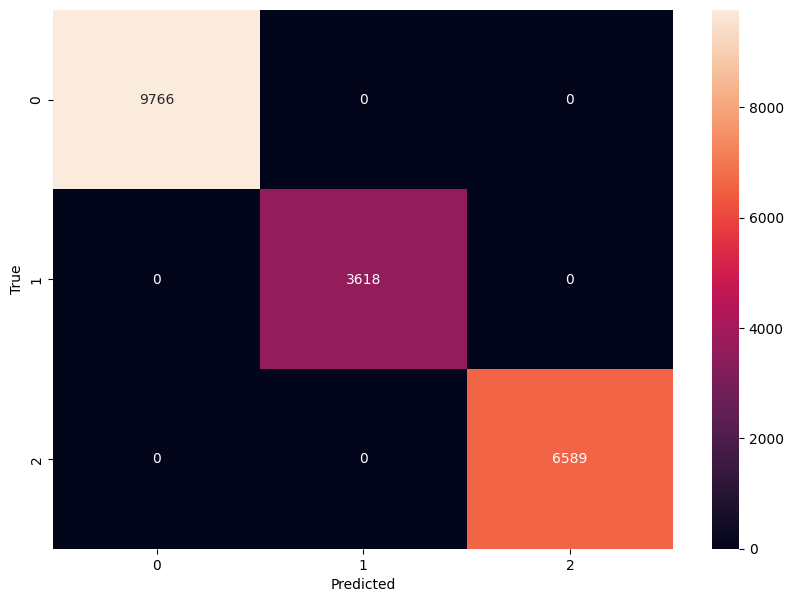

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(features_test_reshaped)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_classes = np.argmax(label_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [96]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load your trained model
model = load_model('/Users/mac/prediction/my_model.h5')

# Load your fitted scaler
scaler = joblib.load('/Users/mac/prediction/my_scaler.pkl')

# Create a new test event
new_event = pd.DataFrame({
    'engine_status': [1],  # new engine_status
    'power_supply_voltage': [22.18],  # new power_supply_voltage
    'oil_value': [3.0],  # new oil_value
    'fuel_liters': [4.6],  # new fuel_liters
    'fuel_change': [-3.6],  # new fuel_change
    'car_age': [0],  # new car_age
    'last_oil_change': [3]  # new last_oil_change
}, index=[0])

# Scale the new event using the saved scaler
new_event_scaled = scaler.transform(new_event)

# # Reshape to 3D array (samples, timesteps, features)
# new_event_array = new_event_scaled.reshape((1, 1, new_event_scaled.shape[1]))

# # Use the Keras model to make a prediction
# prediction = model.predict(new_event_array)


# Reshape to 2D array (samples, features)
new_event_array = new_event_scaled.reshape((1, -1))

# Use the Keras model to make a prediction
prediction = model.predict(new_event_array)


# Get the predicted class
predicted_class = np.argmax(prediction)

print(f"Predicted class: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: 0


/Users/mac/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
